In [1]:
from QMachine.qmachine.pulse_generator.pulse_generator import Pulser #importing my pulser class
from QMachine.qmachine.pulse_generator.simple_funcs import calculate_conversion
import pandas as pd
import numpy as np

In [2]:
def hold_action(channel,time,looped=False):
    return {'action':'hold' , 'channel':channel , 'action_variables':{'time':time},'looped':looped}

def step_action(channel,value,time,looped=False,looped_variable='step_value',loop_index=0):
    return {'action':'step' , 'channel':channel , 'action_variables':{'time':time,'step_value':value},'looped':looped,'looper':looped_variable,'loop_index':loop_index}

def ramp_action(channel,rate,time,looped=False):
    return {'action':'ramp' , 'channel':channel , 'action_variables':{'time':time,'rate':rate},'looped':looped}

def meas_action(channel,type='full',pulse='readout_pulse_0_05',looped=False,buffer_size=16,slices=100,analog_output='out1'):
    return {'action':'meas' , 'channel':channel , 'action_variables':{'type':type , 'pulse':pulse,'buffer_size':buffer_size,'slices':slices,'analog_output':analog_output},'looped':looped}

def ramp_to_zero_action(channel,time=None):
    return {'action':'ramp_to_zero','channel':channel,'action_variables':{'time':time},'looped':False}

In [3]:
dividers = {'ch1': 8.18*1e-3, 'ch2': 8.27*1e-3} #ch1 is BNC36/j5, ch2 is BNC29/j7, the 1e-3 is to account for values listed being in mV not V

factor 2 included to account for high impedance of gates
factor 2 included to account for high impedance of gates
ch1:8.891397050194614
ch2:8.891397050194614


In [4]:
df = pd.read_csv('funnel.csv')
df

,Unnamed: 0,name,time,type,ch1,ch2,m11,m21,m12,m22
0,1,a,10.0,ramp,-6.62,-5.42,False,False,False,True
1,2,b,10.0,ramp,"-6.62, -3.58","-5.42, 6.32",False,False,False,True
2,3,c,15.0,ramp,-0.380,0.325,True,False,False,False
3,4,d,0.2,ramp,"-0.380,30.416,300","0.325,-25.978,300",False,False,False,True
4,5,e,15.0,ramp,-0.380,0.325,True,False,False,False


In [5]:
def make_zero_avg(df,channel):
    other_cols=[i for i in df.columns.values if 'ch' not in i and 'm1' not in i and 'm2' not in i]
    channel_df=df[[channel]+other_cols].copy(deep=True)
    total_offset=0
    for index,row in channel_df.iterrows():
        row[channel]=row[channel].split(',')
        if len(row[channel])==1:
            total_offset+=float(row[channel][0])*float(row['time'])
        if len(row[channel])==2:
            
            total_offset+=(float(row[channel][1])+float(row[channel][0]))/2*float(row['time']) #ramp
        if len(row[channel])==3:
            total_offset+=np.linspace(float(row[channel][0]),float(row[channel][1]),int(row[channel][2]))*float(row['time'])
        # print(total_offset)

    return calc_offset_comp(total_offset)

def calc_offset_comp(offset,correction_len=30):
    return offset/correction_len


zero_avg_ch1=make_zero_avg(df,'ch1')
zero_avg_ch2=make_zero_avg(df,'ch2')
# print(zero_avg_ch1*dividers['ch1'])

In [13]:
time1=int(1e4/4)
time2=int(1.5e4/4)
time3=int(200/4)
time4=int(3e4//4)

time1_r=time1*4
time2_r=time2*4
time3_r=time3*4

ch1_rate=(-3.58-(-6.62))/1e4*dividers['ch1'] #V/ns
ch2_rate=(6.32-(-5.42))/1e4*dividers['ch2'] #V/ns
print(f'ch1_rate,total_change: {ch1_rate,ch1_rate*1e4}, ch2_rate,total_change: {ch2_rate,ch2_rate*1e4}')


# total_v_ch1=-6.62*dividers['ch1']*time1_r+(ch1_rate*1e4*0.5+-6.62*dividers['ch1'])*time1_r+-0.38*dividers['ch1']*time2_r+(-0.38+np.linspace(0,(30.416-(-0.38)),300)*dividers['ch1'])*time3_r+-0.38*dividers['ch1']*time2_r
# total_v_ch2=-5.42*dividers['ch2']*time1_r+(ch2_rate*1e4*0.5+-5.42*dividers['ch2'])*time1_r+0.325*dividers['ch2']*time2_r+(0.325+np.linspace(0,(-25.978-(0.325)),300)*dividers['ch2'])*time3_r+0.325*dividers['ch2']*time2_r
# zero_avg_ch1=(-6.62*10+(-6.62-3.58)/2*10+(-0.38)*15 + np.linspace(-0.38,30.416,300)*0.2 + -0.38*15)/10
# zero_avg_ch2=total_v_ch2/1e4

n_loops=300 #default

actions={'steps':{
                '1':
                    {'ch1':step_action('ch1',-6.62*dividers['ch1'],time1),
                     'ch2':step_action('ch2',-5.42*dividers['ch2'],time1)
                     },
                '2':
                    {'ch1':ramp_action('ch1',ch1_rate,time1),
                     'ch2':ramp_action('ch2',ch2_rate,time1)
                    },
                '3':
                    {
                     'ch1':step_action('ch1',(-0.38-(-3.58))*dividers['ch1'],time2),
                     'ch2':step_action('ch2',(0.325-6.32)*dividers['ch2'],time2),
                     'm1':meas_action('m1','full','readout_pulse_0_2',buffer_size=[n_loops])
                    },
                '4':
                    {'ch1':step_action('ch1',np.linspace(0,(30.416-(-0.38))*dividers['ch1'],n_loops),time3,looped=True,loop_index='0'),
                     'ch2':step_action('ch2',np.linspace(0,(-25.978-(0.325))*dividers['ch2'],n_loops),time3,looped=True,loop_index='0')                        
                    },
                '5':
                    {'ch1':step_action('ch1',-np.linspace(0,(30.416-(-0.38))*dividers['ch1'],n_loops),time2,looped=True,loop_index='0'),
                     'ch2':step_action('ch2',-np.linspace(0,(-25.978-(0.325))*dividers['ch2'],n_loops),time2,looped=True,loop_index='0'),
                     'm1':meas_action('m1','full','readout_pulse_0_2',buffer_size=[n_loops])                        
                    },
                '6':
                    {'ch1':step_action('ch1',zero_avg_ch1*dividers['ch1']-(-0.38*dividers['ch1']),time4,looped=True,loop_index='0'),
                     'ch2':step_action('ch2',zero_avg_ch2*dividers['ch2']-(0.325*dividers['ch2']),time4,looped=True,loop_index='0')
                    },
                '7':
                    {
                    'ch1':ramp_to_zero_action('ch1',1),
                    'ch2':ramp_to_zero_action('ch2',1) #these actions nescessary possibly due to too low resolution on the ramp rate, -> ramp is inprecise?
                    },
                '8':
                    {
                    'ch1':hold_action('ch1',time=time1),
                    # 'ch2':hold_action('ch2',time=time1) #these actions nescessary possibly due to too low resolution on the ramp rate, -> ramp is inprecise?
                    }
                },
        'looped':[n_loops],
        'channels':['ch1','ch2','m1']}




one_loop_time=(3*time1+2*time2+time3+time4)
print(f'loop time in us:{one_loop_time*4/1e3}')


# import pprint
# pprint.pprint(actions)


ch1_rate,total_change: (2.48672e-06, 0.0248672), ch2_rate,total_change: (9.708979999999998e-06, 0.09708979999999999)
loop time in us:90.2


In [14]:
from config import config
pulser=Pulser(config)
pulser.cw_conversion=10
seq,new_actions=pulser.build_seq(actions)

readout length: 15000ns


2022-04-30 14:27:17,991 - qm - INFO - Performing health check
2022-04-30 14:27:18,002 - qm - INFO - Health check passed
quantum machine opened with channels ['Q1_R', 'Q1_L', 'Q1_readout', 'Q2_readout']
default value for CW is: 0.1
2022-04-30 14:27:18,051 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2022-04-30 14:27:18,131 - qm - INFO - Flags: 
2022-04-30 14:27:18,132 - qm - INFO - Simulating program


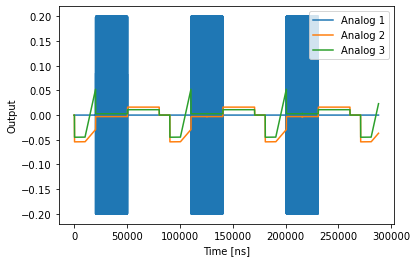

In [15]:
pulser.open_qm(config,close_others=True)
job,samples,figax=pulser.simulate_pulse(seq,simulation_time=int(72e3),close_others=True) #

In [13]:
import matplotlib.pyplot as plt
%matplotlib widget
meas_channel=1
fig,ax=plt.subplots()
ax2=ax.twinx()
measurement_on_points=np.where(samples.con1.analog[str(meas_channel)]!=0)
ax.plot(samples.con1.analog['3'],label='ch2')
ax.plot(samples.con1.analog['2'],label='ch1')
# ax.hlines(0,0,len(samples.con1.analog['3']))
fig.canvas.draw()
y_ticks=ax.get_yticks()
# ax.set_yticks(ticks=[-0.06,0,0.06],labels=['-60','0','60'])
ax.set_ylabel('V')
ax2.plot(measurement_on_points,np.ones(len(measurement_on_points)),'.',label='m1')
ax2.set_ylim(0,1.05)
ax.set_xlabel('time ns')
ax.set_ylabel('OPX output voltage')
fig.legend()
# plt.show()


KeyboardInterrupt: 

In [9]:
pulser.open_qm(config=config,close_others=True)
job=pulser.qm.execute(seq)
job.halt()
all_results= {key : item.fetch_all() for key,item in job.result_handles._all_results.items()}

2022-04-29 16:49:02,429 - qm - INFO - Performing health check
2022-04-29 16:49:02,439 - qm - INFO - Health check passed
quantum machine opened with channels ['Q1_R', 'Q1_L', 'Q1_readout', 'Q2_readout']
default value for CW is: 0.1
2022-04-29 16:49:02,551 - qm - INFO - Flags: 
2022-04-29 16:49:02,552 - qm - INFO - Sending program to QOP
2022-04-29 16:49:03,482 - qm - INFO - Executing program


Text(0, 0.5, 'amplitude V')

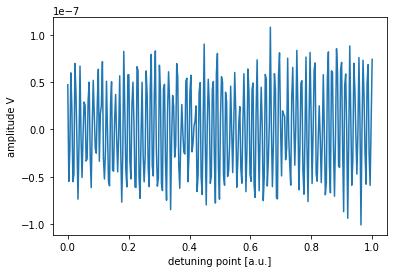

In [12]:
before = all_results['I_1']**2+all_results['Q_1']**2
after = all_results['I_2']**2+all_results['Q_2']**2
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,1,300),after-before)
plt.xlabel('detuning point [a.u.]')
plt.ylabel('amplitude V')

# making simpler pulses to check the signal

In [38]:
n_averages=50
n_steps=50
n_slices=50
total_meas_time=200e3
correction_pulse_time=0.5
time_per_step=total_meas_time*(1-correction_pulse_time)/n_steps
print(f'time per row: {time_per_step*1e-3}us')
rate=50*dividers['ch2']/time_per_step

cycles_per_step=int(time_per_step/4)

total_applied_ch1 = total_meas_time*(1-correction_pulse_time)*25
offset_corr=-total_applied_ch1/(correction_pulse_time*total_meas_time)
print(f'offset correction value {offset_corr}')
time_per_offset=total_meas_time*(correction_pulse_time)/n_steps
cycles_per_offset=int(time_per_offset/4)
print(f'cycles per offset: {cycles_per_offset}')

actions_2d={'steps':{
                '1':
                    {'ch1':step_action('ch1',value=np.ones(n_averages)*0.3,time=cycles_per_step,looped=True,loop_index='0') #np.linspace(0,50,n_steps)*dividers['ch1']
                #      'ch2':ramp_action('ch2',rate,cycles_per_step),
                #      'm1':meas_action('m1',type='sliced',pulse='readout_pulse_0_2',slices=n_slices,buffer_size=(n_slices,n_steps))
                     },
                '2':
                    {'ch1':hold_action('ch1',time=cycles_per_step)}#,
                #      'ch2':step_action('ch2',offset_corr*dividers['ch1'],cycles_per_offset)
                #     }
                },
        'looped':[n_averages],
        'channels':['ch1']}

print(f'total time for first loop: {(n_steps*time_per_step+time_per_offset)/1000}us')
import pprint
# pprint.pprint(actions_2d)
    

time per row: 2.0us
offset correction value -25.0
cycles per offset: 500
total time for first loop: 102.0us


readout length: 1000ns
1
2022-04-30 14:35:40,099 - qm - INFO - Performing health check
2022-04-30 14:35:40,111 - qm - INFO - Health check passed
quantum machine opened with channels ['Q1_R', 'Q1_L', 'Q1_readout', 'Q2_readout']
default value for CW is: 0.1
2022-04-30 14:35:40,162 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2022-04-30 14:35:40,196 - qm - INFO - Flags: 
2022-04-30 14:35:40,197 - qm - INFO - Simulating program
10.0


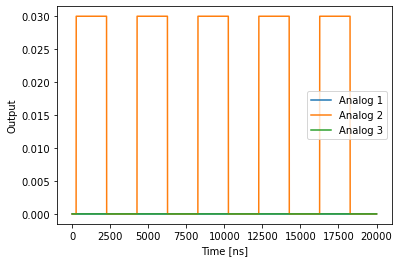

In [37]:
from config_not_sticky import config as config_not_s
# config_not_s = config
if 'hold_offset' in config_not_s['elements']['Q1_R'].keys():
    raise Exception('sticky element detected')
pulser_n_s=Pulser(config_not_s)
# pulser_n_s.open_qm(pulser_n_s.config,close_others=True)
seq_2d,new_actions=pulser_n_s.build_seq(actions_2d)
# pprint.pprint(new_actions)
print(pulser_n_s.cw_conversion)
pulser_n_s.open_qm(config=config_not_s,close_others=True)
job,samples,figax=pulser_n_s.simulate_pulse(seq_2d,simulation_time=int(20e3/4),close_others=True) 
print(pulser_n_s.cw_conversion)

readout length: 15000ns
2022-04-30 14:35:50,365 - qm - INFO - Performing health check
2022-04-30 14:35:50,378 - qm - INFO - Health check passed
quantum machine opened with channels ['Q1_R', 'Q1_L', 'Q1_readout', 'Q2_readout']
default value for CW is: 0.1
2022-04-30 14:35:50,444 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2022-04-30 14:35:50,490 - qm - INFO - Flags: 
2022-04-30 14:35:50,491 - qm - INFO - Simulating program


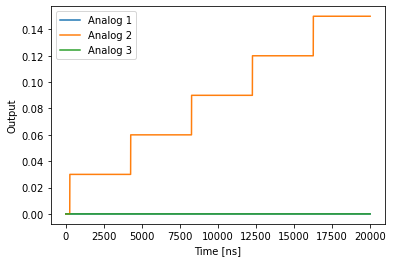

In [39]:
from config import config
pulser=Pulser(config)
pulser.cw_conversion=10
seq,new_actions=pulser.build_seq(actions_2d)
pulser.open_qm(config,close_others=True)
job,samples,figax=pulser.simulate_pulse(seq_2d,simulation_time=int(20e3/4),close_others=True) 

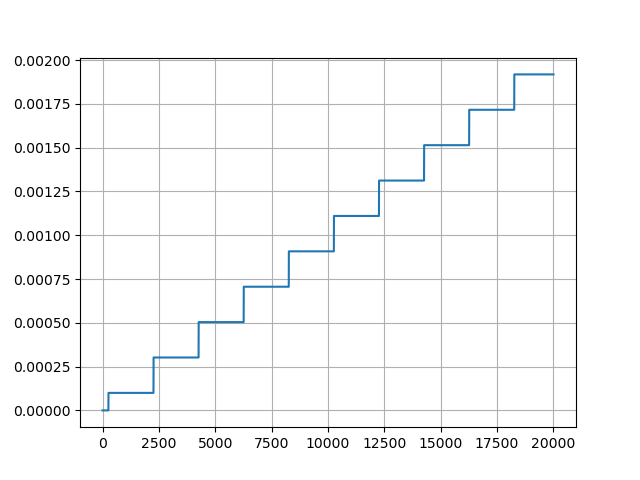

In [12]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib widget
plt.plot(samples.con1.analog['2'])
plt.grid()

In [29]:
np.linspace(0,50,n_steps)*dividers['ch1']*10

array([0.        , 0.08346939, 0.16693878, 0.25040816, 0.33387755,
       0.41734694, 0.50081633, 0.58428571, 0.6677551 , 0.75122449,
       0.83469388, 0.91816327, 1.00163265, 1.08510204, 1.16857143,
       1.25204082, 1.3355102 , 1.41897959, 1.50244898, 1.58591837,
       1.66938776, 1.75285714, 1.83632653, 1.91979592, 2.00326531,
       2.08673469, 2.17020408, 2.25367347, 2.33714286, 2.42061224,
       2.50408163, 2.58755102, 2.67102041, 2.7544898 , 2.83795918,
       2.92142857, 3.00489796, 3.08836735, 3.17183673, 3.25530612,
       3.33877551, 3.4222449 , 3.50571429, 3.58918367, 3.67265306,
       3.75612245, 3.83959184, 3.92306122, 4.00653061, 4.09      ])

In [7]:
pulser_n_s.cw_conversion

10.0

In [8]:
new_actions

{'steps': {'1': {'ch1': {'action': 'step',
    'channel': 'ch1',
    'action_variables': {'time': 500,
     'step_value': <qm.qua._dsl._Expression at 0x1e1131cfee0>},
    'looped': True,
    'looper': 'step_value',
    'loop_index': '0',
    'loop_param': <qm.qua._dsl._Expression at 0x1e1131ce9e0>}}},
 'looped': [50],
 'channels': ['ch1', 'ch2', 'm1']}

In [36]:
from config_not_sticky import config
from qm.qua import program,for_,stream_processing,declare,declare_stream,wait,measure,play,save,fixed,demod,ramp,amp,if_,elif_,else_,align, ramp_to_zero
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig

qmm = QuantumMachinesManager(host='192.168.15.128',port=80)
qmm.close_all_quantum_machines()
qm = qmm.open_qm(config)

analog_to_Q = {'1':'r','2':'Q1_L','3':'Q1_R','4':'Q2_R'}


2022-04-30 15:09:28,841 - qm - INFO - Performing health check
2022-04-30 15:09:28,853 - qm - INFO - Health check passed


2022-04-30 15:12:56,561 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2022-04-30 15:12:56,602 - qm - INFO - Flags: 
2022-04-30 15:12:56,604 - qm - INFO - Simulating program


Text(0.5, 1.0, 'b=1')

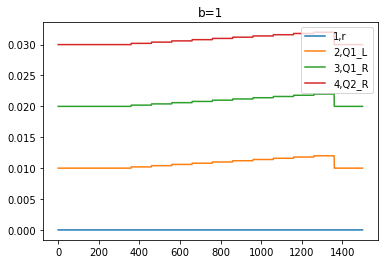

In [47]:
import numpy as np
b=1 #some multiplication factor
with program() as sprog:
    test=declare(int) #for loop index
    b_dec=declare(fixed,value=b) #some multiplication factor as declared value
    test_array=declare(fixed,value=np.linspace(0,0.02,11)) #array of values for all to loop over

    with for_(test,0,test<11,test+1):
        play('CW'*amp(test_array[test]*b), 'Q1_L', duration=int(100/4))
        play('CW'*amp(test_array[test]*b_dec), 'Q1_R', duration=int(100/4))
        play('CW'*amp(test_array[test]), 'Q2_R', duration=int(100/4))
        
    


job = qm.simulate(sprog, SimulationConfig(int(1500//4)))
samples = job.get_simulated_samples()
# samples.con1.plot()

import matplotlib.pyplot as plt
plt.figure()
for sample in range(4):
    plt.plot(samples.con1.analog[str(sample+1)]+sample*0.01,label=f'{sample+1},{analog_to_Q[str(sample+1)]}')
plt.legend()
plt.title(f'b={b}')

# below is testing whether it had to do with the array

2022-04-30 15:13:15,780 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2022-04-30 15:13:15,814 - qm - INFO - Flags: 
2022-04-30 15:13:15,816 - qm - INFO - Simulating program


Text(0.5, 1.0, 'b=10')

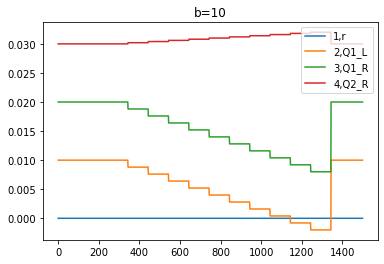

In [49]:
import numpy as np
b=10 #some multiplication factor
with program() as sprog:
    test=declare(fixed) #for loop index
    b_dec=declare(fixed,value=b) #some multiplication factor as declared value
    # test_array=declare(fixed,value=np.linspace(0,0.02,30)) #array of values for all to loop over

    with for_(test,0,test<0.02+0.001,test+0.002):
        play('CW'*amp(test*b), 'Q1_L', duration=int(100/4))
        play('CW'*amp(test*b_dec), 'Q1_R', duration=int(100/4))
        play('CW'*amp(test), 'Q2_R', duration=int(100/4))
        
    


job = qm.simulate(sprog, SimulationConfig(int(1500//4)))
samples = job.get_simulated_samples()
# samples.con1.plot()

import matplotlib.pyplot as plt
plt.figure()
for sample in range(4):
    plt.plot(samples.con1.analog[str(sample+1)]+sample*0.01,label=f'{sample+1},{analog_to_Q[str(sample+1)]}')
plt.legend()
plt.title(f'b={b}')